In [1]:
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import math

# Adjust the path for c2qa and bosonic-qiskit modules
module_path = os.path.abspath(os.path.join('..', '..', '..'))  # Moves three directories up
if module_path not in sys.path:
    sys.path.append(module_path)

# Add the `playground` directory to the Python path
playground_path = Path.cwd().parent.parent  # Move two levels up to `playground`
if str(playground_path) not in sys.path:
    sys.path.append(str(playground_path))


# Qiskit and related imports
import qiskit
from qiskit.quantum_info import state_fidelity, Statevector, SparsePauliOp, Operator, Clifford
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate, UnitaryGate
from qiskit.synthesis import LieTrotter, SuzukiTrotter
import qutip as qt
from qiskit import transpile


# Project-specific imports
import c2qa
import c2qa.util as util

[ref](https://arxiv.org/pdf/2312.05344)


Here we focus on the axial-vector term of the pion-nucleon interaction Hamiltonian. We consider a three dimensional lattice $N\times N\times N$, with spacing $a_L$. The pion field at lattice site $x$ is represented by $\pi_I(x)$ for the isospin indices $I\in\{1,2,3\}$. The fermionic annihilation and creation operators at site $x$ for species $\sigma$ are  $a_\sigma(x)$ and $a_\sigma^\dagger(x)$, respectively, where $\sigma$ runs over protons, neutrons, and their spin states: $\sigma \in \{\uparrow, \downarrow\} \times \{\text{proton}, \text{neutron}\}$, i.e. $ a_{00}(x) = a_{\uparrow p}(x)$,  $ a_{01}(x) = a_{\uparrow n}(x)$,  $ a_{10}(x) = a_{\downarrow p}(x)$,  $ a_{11}(x) = a_{\downarrow n}(x)$. The axial-vector term is
$$
H_{AV} = \frac{g_A}{2 f_\pi} \sum_{x} \sum_{\alpha,\beta,\gamma,\delta} \sum_{I=1}^3 \sum_{S=1}^3 a^\dagger_{\alpha\beta}(x) \left[\tau_I\right]_{\beta\delta} \left[\sigma_S\right]_{\alpha\gamma} \partial_S\,\pi_I(x) \; a_{\gamma\delta}(x),
$$
where we define the Pauli matrices $\sigma_S$ (with $S\in\{1,2,3\}$) as operators on the spin space, and the matrices $\tau_I$ (with $I\in\{1,2,3\}$) as operators on the isospin space, with

$$
\sigma_1 = \tau_1 = X,\quad \sigma_2 = \tau_2 = Y,\quad \sigma_3 = \tau_3 = Z.
$$

Here, the notation $\left[\sigma_S\right]_{\alpha\beta}$ indicates the $(\alpha,\beta)$ entry of the matrix $\sigma_S$. From which, we get 36 non-zero terms per site.

We can quantize the pion fields in the standard way such that we obtain an expansion in terms of the (bosonic) creation $b_k^\dag$ and anhillation $b_k$ operators,
$$
\pi_I(x) = \frac{1}{\sqrt{V}} \sum_{k} \frac{1}{\sqrt{2\omega_k}} \left( a_I(k) e^{\frac{i2\pi\, k\cdot x}{N}} + a_I^\dagger(k) e^{\frac{-i2\pi\, k\cdot x}{N}} \right),
$$
with the momentum vector is defined as $k = (k_1,k_2,k_3), k_i \in \left[-\frac{N}{2},\,\frac{N}{2}-1\right],$ i.e. $k$ labels the corresponding momentum mode, and $V = N^3$.

### Highest Weight
The highest weight term in the sum will be e.g.
$$
\frac{\pi_1(x + a_L \hat{n}_1) - \pi_1(x)}{a_L}
\left[
a_{\uparrow p}^\dagger(x) a_{\downarrow n}(x)
\right],
$$
where $\hat{n}_j$ is the unit vector along the cartesian coordinate $j$.

### Lowest Weight 
The lowest weight term in the sum will be e.g.
$$
\frac{\pi_3(x + a_L \hat{n}_3) - \pi_3(x)}{a_L}
\left[
a_{\uparrow p}^\dagger(x) a_{\uparrow p}(x)
\right],
$$
where $\hat{n}_j$ is the unit vector along the cartesian coordinate $j$.

# 2 Site Model
In our two-site model, we have only one spatial link, so a full three-dimensional derivative is not defined. Therefore, we restrict the derivative to a single direction. For concreteness, we choose $S=3$,
$$
H_{AV}^{\text{2-site}} = \frac{g_A}{2 f_\pi} \sum_{x=1}^2 \sum_{\alpha,\beta,\gamma,\delta} \sum_{I=1}^{3} a^\dagger_{\alpha\beta}(x) \left[\tau_I\right]_{\beta\delta} \left[\sigma_3\right]_{\alpha\gamma} \partial_3\,\pi_I(x) \; a_{\gamma\delta}(x).
$$

In this reduced model, the only nontrivial derivative is along the third spatial direction. The only non-zero terms will occur when $\alpha = \gamma$, hence we can write 
$$
H_{AV}^{\text{2-site}} = \frac{g_A}{2 f_\pi}\, \sum_{x=1}^{2} \sum_{\beta, \delta} \sum_{I=1}^{3} \left[ a_{0\beta}^\dagger(x) [\tau_I]_{\beta\delta} \, a_{0\delta}(x) - a_{1\beta}^\dagger(x) [\tau_I]_{\beta\delta} \, a_{1\delta}(x) \right]\partial_3 \pi_I(x),
$$
which we can see will give us a total of 12 non-zero terms per lattice site in the sum.

### A Single Pion Isospin
To begin, we choose a simplification of $I = 3$. Thus, our Hamiltonian is
$$
H_{AV}^{\text{2-site}}\Big|_{I=3} = \frac{g_A}{2 f_\pi}\sum_{x=1}^{2}\left\{
a^\dagger_{00}(x)a_{00}(x) - a^\dagger_{01}(x)a_{01}(x) - a^\dagger_{10}(x)a_{10}(x) + a^\dagger_{11}(x)a_{11}(x)
\right\}\partial_3\pi_3(x),
$$
$$
= \frac{g_A}{2 f_\pi}\sum_{x=1}^{2}\left\{
a^\dagger_{00}(x)a_{00}(x) - a^\dagger_{01}(x)a_{01}(x) - a^\dagger_{10}(x)a_{10}(x) + a^\dagger_{11}(x)a_{11}(x)
\right\}\times \sum_{m=1}^{2} \frac{1}{\sqrt{2\omega_m}} \Bigl\{ b_m\,\Bigl(e^{i\pi m (x+1)}-e^{i\pi m x}\Bigr) + b_m^\dagger\,\Bigl(e^{-i\pi m (x+1)}-e^{-i\pi m x}\Bigr) \Bigr\}\,.
$$
Where we use the finite derivative $ \frac{\pi_3(x + a_L)-\pi_3(x)}{a_L}$ and expanding the scalar field in terms of momentum modes in the second line.
We can now map this expression to spin-boson degrees of freedom. For each fermionic mode at lattice site $x$, we use the mapping
$$
a_{ij}^\dagger(x)a_{ij}(x) = \frac{1}{2}\Bigl( I + Z_{ij}(x) \Bigr), \quad ij\in\{00, 01, 10, 11\},
$$
which we can see means the identity pieces cancel (since $I - I - I + I = 0$), leaving only a combination of the $Z$ operators. Thus,
$$
\begin{aligned}
H_{AV}^{\text{2-site}}\Big|_{I=3} &= \frac{g_A}{4 f_\pi\, a_L\sqrt{2}} \sum_{x=1}^{2} \Bigl[ Z_{00}(x)-Z_{01}(x)-Z_{10}(x)+Z_{11}(x)\Bigr] \\
&\quad \times \sum_{m=1}^{2} \frac{1}{\sqrt{2\omega_m}} \Bigl\{ b_m\,\Bigl(e^{i\pi m (x+1)}-e^{i\pi m x}\Bigr) + b_m^\dagger\,\Bigl(e^{-i\pi m (x+1)}-e^{-i\pi m x}\Bigr) \Bigr\}\,.
\end{aligned}
$$
Given that for any even momentum index the phase factors cancel in the finite‐difference derivative, the final Hamiltonian is

$$
\boxed{
H_{AV}^{\text{2-site}}\Big|_{I=3} = \frac{g_A}{4f_\pi\,a_L\sqrt{2\omega_1}}
\left\{
\Bigl[Z_{00}(1)-Z_{01}(1)-Z_{10}(1)+Z_{11}(1)\Bigr]
-\Bigl[Z_{00}(2)-Z_{01}(2)-Z_{10}(2)+Z_{11}(2)\Bigr]
\right\}(b_1+b_1^\dagger).
}
$$
This corresponds to 8 conditonal displacements.

In [2]:
def create_quantum_circuit(num_sites=2, num_qubits_per_qumode=1):
    """Create and initialize the circuit
    We have 1 pion isospin, so 1 oscillator per site. 
    We have 4 fermionic species, so 4 qubits per site.
    """
    num_qubits = 4*num_sites
    # Create registers
    qmr = c2qa.QumodeRegister(num_qumodes=num_sites, 
                             num_qubits_per_qumode=num_qubits_per_qumode)
    qbr = qiskit.QuantumRegister(num_qubits)
    circuit = c2qa.CVCircuit(qmr, qbr)

    #prepare a spin up proton at site 1
    circuit.initialize([0,1], qbr[0])
    
    return circuit, qmr, qbr

def trotter_two_site_H_av(circuit, qmr, qbr, prefactor, dt, steps):
    for step in range(steps):
        # --- Site 1 ---
        # qubit 0 (Z_00): +1 coefficient
        circuit.cv_c_d(-1j * prefactor * dt, qmr[0], qbr[0])
        # qubit 1 (Z_01): -1 coefficient
        circuit.cv_c_d( 1j * prefactor * dt, qmr[0], qbr[1])
        # qubit 2 (Z_10): -1 coefficient
        circuit.cv_c_d( 1j * prefactor * dt, qmr[0], qbr[2])
        # qubit 3 (Z_11): +1 coefficient
        circuit.cv_c_d(-1j * prefactor * dt, qmr[0], qbr[3])
        
        # --- Site 2 ---
        # overall sign flips, so effective factor = -prefactor.
        # qubit 4 (Z_00): +1 
        circuit.cv_c_d(-1j * (-prefactor) * dt, qmr[1], qbr[4])
        # qubit 5 (Z_01): -1 
        circuit.cv_c_d( 1j * (-prefactor) * dt, qmr[1], qbr[5])
        # qubit 6 (Z_10): -1 
        circuit.cv_c_d( 1j * (-prefactor) * dt, qmr[1], qbr[6])
        # qubit 7 (Z_11): +1 
        circuit.cv_c_d(-1j * (-prefactor) * dt, qmr[1], qbr[7])
    
    return circuit

def run_simulation(circuit):
    state, _, _ = c2qa.util.simulate(circuit)
    return state

def simulate_two_site_H_av(num_sites, num_qubits_per_qumode, prefactor, dt, steps):
    """
    Simulate the two-site axial vector term of the pion-nucleon interaction Hamiltonian
    using a trotter decomp for a single pion isospin.
    """
    num_sites = 2
    
    # Create and initialize the circuit
    circuit, qmr, qbr = create_quantum_circuit(num_sites, num_qubits_per_qumode)
    
    # Apply Trotter steps
    circuit = trotter_two_site_H_av(circuit, qmr, qbr, prefactor, dt, steps)
    
    # Run the simulation
    state = run_simulation(circuit)
    
    return state 

In [3]:
def qutip_simulate_av(prefactor, t_max, numsteps):
    num_sites = 2
    nq        = 2
    dim       = 2**nq

    # initial state
    osc = [qt.basis(dim, 0) for _ in range(num_sites)]
    qb  = [qt.basis(2,   0) for _ in range(4*num_sites)]
    qb[0] = qt.basis(2, 1)
    psi0 = qt.tensor(*(osc + qb))

    # dims for tensor ops
    dims = [dim]*num_sites + [2]*(4*num_sites)

    # bosonic modes
    b, bd = [], []
    for m in range(num_sites):
        ops= [qt.qeye(d) for d in dims]
        ops[m] = qt.destroy(dim)
        bm = qt.tensor(ops)
        b.append(bm)
        bd.append(bm.dag())

    # fermion number op
    def n_op(x, j):
        idx = num_sites + 4*(x-1) + j
        ops= [qt.qeye(d) for d in dims]
        ops[idx] = qt.destroy(2).dag() * qt.destroy(2)
        return qt.tensor(ops)

    # build H with periodic boundary conditions
    H = 0
    signs = {0: +1, 1: -1, 2: -1, 3: +1}
    for x in (1, 2):
        A = sum(signs[j] * n_op(x, j) for j in signs)
        # wrap x+1 -> 1 when x == num_sites
        x_next = (x % num_sites) + 1
        for m_idx in range(num_sites):
            m_phys = m_idx + 1
            ph1    = np.exp(1j * np.pi * m_phys * x_next)
            ph2    = np.exp(1j * np.pi * m_phys * x)
            H += prefactor * A * (
                b[m_idx] * (ph1 - ph2)
              + bd[m_idx] * (np.conj(ph1) - np.conj(ph2))
            )

    times = np.linspace(0, t_max, numsteps)
    return qt.mesolve(H, psi0, times, [], []) 

###  Loschmidt echo

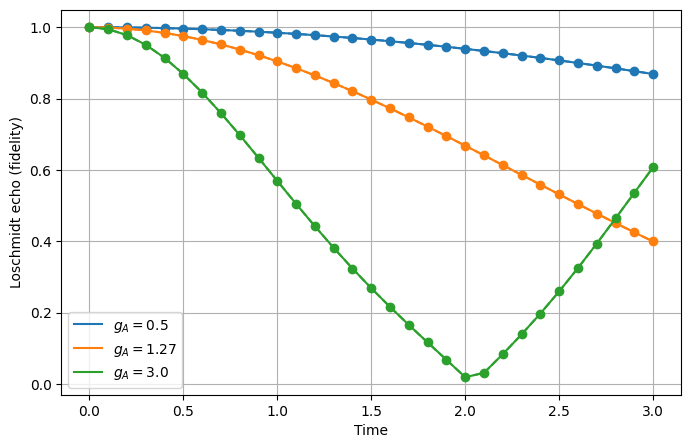

In [4]:
from qutip import basis, tensor, Qobj, fidelity as qt_fidelity

# Trotter params
t_max, dt = 3.0, 0.1
times_trot = np.arange(0, t_max + dt, dt)

# fixed Constants
f_pi = 1.0
a_L = 1.0
omega1 = 1.0

# System size
num_sites = 2
num_qubits_per_qumode = 2
dim = 2 ** num_qubits_per_qumode

# Target state
osc_states = [basis(dim, 0) for _ in range(num_sites)]
qb_states  = [basis(2, 0) for _ in range(4 * num_sites)]
qb_states[0] = basis(2, 1)  # up on site 1
target = tensor(*(osc_states + qb_states))
target_rev = target.permute(list(range(len(target.dims[0])))[::-1])  # Qutip order

# vary g_a
gA_list = [0.5, 1.27, 3.0]

# Plot
plt.figure(figsize=(8, 5))

for i, g_A in enumerate(gA_list):
    colour = f'C{i}'                     # palette
    prefactor = g_A / (4 * f_pi * a_L * np.sqrt(2 * omega1))

    # Trotter
    fids_trot = []
    for t in times_trot:
        steps = int(t / dt)
        raw_state = simulate_two_site_H_av(
            num_sites,
            num_qubits_per_qumode,
            prefactor,
            dt,
            steps
        )
        qt_state = Qobj(raw_state, dims=target_rev.dims)
        fids_trot.append(qt_fidelity(target_rev, qt_state))

    # Exact
    res = qutip_simulate_av(prefactor, t_max=t_max, numsteps=len(times_trot))
    fids_exact = [qt_fidelity(res.states[0], st) for st in res.states]

    plt.plot(res.times,   fids_exact, '-',  color=colour,
             label=fr'$g_A={g_A}$')          # legend
    plt.plot(times_trot, fids_trot,  'o--', color=colour,
             label='_nolegend_')             # no legend

plt.xlabel('Time')
plt.ylabel('Loschmidt echo (fidelity)')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

In the above, solid lines correspond to exact qutip result and markers from trotter circ.

### More Cross Checks

### I = 1 ISOSPIn
$$
H_{AV}^{\text{2‑site}}\Big|_{I=1}
  = \frac{g_A}{2 f_\pi}\,
    \sum_{x=1}^{2}
    \sum_{\beta,\delta}
    \Bigl[
      a_{0\beta}^\dagger(x)\,[\tau_{1}]_{\beta\delta}\,a_{0\delta}(x)
      \;-\;
      a_{1\beta}^\dagger(x)\,[\tau_{1}]_{\beta\delta}\,a_{1\delta}(x)
    \Bigr]\,
    \partial_{3}\pi_{1}(x).
$$
$$
 = \frac{g_A}{2f_\pi}\,
    \sum_{x=1}^{2}
    \Bigl[
      \bigl(a_{00}^\dagger(x)\,a_{01}(x)
            + a_{01}^\dagger(x)\,a_{00}(x)
      \;-\;
      a_{10}^\dagger(x)\,a_{11}(x)
            - a_{11}^\dagger(x)\,a_{10}(x)\bigr)
    \Bigr]\,
\times \sum_{m=1}^{2} \frac{1}{\sqrt{2\omega_m}} \Bigl\{ b_m\,\Bigl(e^{i\pi m (x+1)}-e^{i\pi m x}\Bigr) + b_m^\dagger\,\Bigl(e^{-i\pi m (x+1)}-e^{-i\pi m x}\Bigr) \Bigr\}\,.
$$
Following Verstraete–Cirac encoding used in arXiv:2312.05344, the VC annihilation operators on site $x$ are  
$$
\tilde a_{00}=\tfrac12\,(X_{00}+iY_{00}),\quad
\tilde a_{01}=\tfrac12\,Z_{00}(X_{01}+iY_{01}),$$
$$\tilde a_{10}=\tfrac12\,Z_{00}Z_{01}(X_{10}+iY_{10}),\quad
\tilde a_{11}=\tfrac12\,Z_{00}Z_{01}Z_{10}(X_{11}+iY_{11}).
$$
We find that
$$
a^{\dagger}_{00} a_{01} + a^{\dagger}_{01} a_{00} = \tfrac12\,(X_{00}X_{01}+Y_{00}Y_{01})\,Z_{00},
$$
$$
a^{\dagger}_{10} a_{11} + a^{\dagger}_{11} a_{10} = \tfrac12\,(X_{10}X_{11}+Y_{10}Y_{11})\,Z_{10}. 
$$
Thus, using $XZ = -iY, YZ = iX$,
$$
H_{AV}^{\text{2‑site}}\Big|_{I=1}
 = \frac{g_A}{4f_\pi}\,
    \sum_{x=1}^{2}
    i\Bigl[(X_{00}(x)Y_{01}(x)-Y_{00}(x)X_{01}(x))-(X_{10}(x)Y_{11}(x)-Y_{10}(x)X_{11}(x))\Bigr]
\,
\times \sum_{m=1}^{2} \frac{1}{\sqrt{2\omega_m}} \Bigl\{ b_m\,\Bigl(e^{i\pi m (x+1)}-e^{i\pi m x}\Bigr) + b_m^\dagger\,\Bigl(e^{-i\pi m (x+1)}-e^{-i\pi m x}\Bigr) \Bigr\}\,.
$$
Using the same method as the $I = 3$ case,
$$
H_{AV}^{\text{2‑site}}\Big|_{I=1}
= \frac{ig_A}{2f_\pi\sqrt{2\omega_1}}\,
\Bigl[
\bigl(X_{00}(1)Y_{01}(1)-Y_{00}(1)X_{01}(1)\bigr)
-\bigl(X_{10}(1)Y_{11}(1)-Y_{10}(1)X_{11}(1)\bigr)\\
\quad
-\bigl(X_{00}(2)Y_{01}(2)-Y_{00}(2)X_{01}(2)\bigr)
+\bigl(X_{10}(2)Y_{11}(2)-Y_{10}(2)X_{11}(2)\bigr)
\Bigr]
\,(b_1 + b_1^\dagger)\,. 
$$

##### Compiling $X_{00}Y_{01} (b_1 + b_1^\dagger)$
$$
e^{-i X_0 Y_1 (\alpha b^\dagger  + \alpha^*b)} = H_0 \cdot S_1 H_1 \cdot C\Pi_{1,k} \cdot CD_{0,k}(-\alpha) \cdot C\Pi_{1,k}^\dagger \cdot  H_1 S_1^\dagger\cdot H_0.
$$
Where we use the bosonic qiskit definition of diplacement $D(\alpha) = e^{\alpha a^\dagger - \alpha^*a}$, and $C\Pi_{ij} = e^{-i \frac{\pi}{2} Z_i n_j}$. We can show this anayltically following arXiv2409.03747, but let us write the gate sequence in bosonic qiskit, and qutip, to verify we're producing the correct overall unitary. 

In [7]:
# build annihilation to cutoff n
def annihil(n):
    a = np.zeros((n, n), dtype=complex)
    for m in range(1, n):
        a[m-1, m] = np.sqrt(m)
    return a

def compute_metrics(alpha):
    # parameters
    num_qubits_per_qumode = 1
    n_cut = 2**num_qubits_per_qumode        
    GLOBAL_DIM = 2*2 * n_cut               
    
    # ladder & quadrature
    a    = annihil(n_cut)
    adag = a.conj().T
    x_op = alpha*adag + np.conj(alpha)*a

    # Pauli for little‑endian Qiskit
    X, Y = np.array([[0,1],[1,0]],complex), np.array([[0,-1j],[1j,0]],complex)
    XY   = np.kron(Y, X)   # qubit‑1 ⊗ qubit‑0 ordering

    # build circuit
    qmr = c2qa.QumodeRegister(1, num_qubits_per_qumode=1)
    qbr = qiskit.QuantumRegister(2)
    circ = c2qa.CVCircuit(qmr, qbr)

    circ.h    (qbr[0])
    circ.s    (qbr[1])
    circ.h    (qbr[1])
    circ.cv_c_r(np.pi/2, qmr[0], qbr[1])
    circ.cv_c_d(-alpha, qmr[0], qubit=qbr[0])
    circ.cv_c_r(-np.pi/2, qmr[0], qbr[1])
    circ.h    (qbr[1])
    circ.sdg  (qbr[1])
    circ.h    (qbr[0])

    U_circ = Operator(circ).data

    # target unitary
    U_tgt  = expm(-1j * np.kron(XY, x_op))

    # compare
    phase     = np.vdot(U_circ.flatten(), U_tgt.flatten())
    phase    /= abs(phase)
    frob_err  = np.linalg.norm(U_circ - phase*U_tgt)
    fid       = abs(np.trace(U_circ.conj().T @ U_tgt)) / GLOBAL_DIM

    return frob_err, fid

for alpha in [1.0, 1.0j, 0.5, 0.5j, 0.5+0.5j]:
    eps, F = compute_metrics(alpha)
    print(f"α={α:>5}  →  ‖U_circ−U_tgt‖_F = {eps:.2e},  fidelity = {F:.6f}")

α=(0.5+0.5j)  →  ‖U_circ−U_tgt‖_F = 1.31e-15,  fidelity = 1.000000
α=(0.5+0.5j)  →  ‖U_circ−U_tgt‖_F = 1.51e-15,  fidelity = 1.000000
α=(0.5+0.5j)  →  ‖U_circ−U_tgt‖_F = 8.95e-16,  fidelity = 1.000000
α=(0.5+0.5j)  →  ‖U_circ−U_tgt‖_F = 8.95e-16,  fidelity = 1.000000
α=(0.5+0.5j)  →  ‖U_circ−U_tgt‖_F = 1.23e-15,  fidelity = 1.000000
